# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from scipy import sparse
import torch

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
DATA_DIR = os.path.join("..", "data", "final_dataset")

In [3]:
df = pd.read_parquet(os.path.join(DATA_DIR, 'ratings.parquet'))
books= pd.read_parquet(os.path.join(DATA_DIR, 'books_all.parquet'))
df = df[df["isbn"].isin(books["isbn"])]
df = df.query("provided_rating!=0")
df.reset_index(drop=True, inplace=True)
print(f"Number of ratings: {len(df)}")
print(f"Number of unique users: {df['user_id'].nunique()}")
print(f"Number of books: {df['isbn'].nunique()}")
df.head()

Number of ratings: 104756
Number of unique users: 31940
Number of books: 22020


,user_id,isbn,provided_rating
0,17,0891075275,6
1,17,0553264990,5
2,26,0449005615,9
3,39,0671888587,7
4,69,1853260053,8


## Smaller Dataset

In [4]:
num_ratings = df.groupby('isbn')['provided_rating'].count().sort_values(ascending=False)
most_rated_books = num_ratings.index[:10]
num_ratings = df.groupby('isbn')['provided_rating'].count().sort_values(ascending=False)
most_rated_books = num_ratings.index[:10]
num_ratings.head()

isbn
0316666343    707
0060928336    320
0671027360    269
067976402X    256
0786868716    242
Name: provided_rating, dtype: int64

In [5]:
df.groupby('user_id')['provided_rating'].count().sort_values(ascending=False)

user_id
11676     1593
98391      595
189835     371
76499      333
153662     322
          ... 
59675        1
157184       1
59685        1
59697        1
278854       1
Name: provided_rating, Length: 31940, dtype: int64

In [6]:
ratings = pd.DataFrame(df.groupby('isbn')['provided_rating'].mean())
ratings['num_ratings'] = pd.DataFrame(df.groupby('isbn')['provided_rating'].count())
ratings.head()

,provided_rating,num_ratings
isbn,,
0002163578,5.0,1
0002190915,9.5,2
0002210479,6.0,1
0002222469,8.0,1
0002241358,8.0,1


In [7]:
min_ratings = 5
books_ = ratings.query(f"num_ratings > {min_ratings}").index
print(f"Number of books_ with more than {min_ratings} ratings: {len(books_)}")
print(f"Original number of books_: {df['isbn'].nunique()}")
print(f"Number of rows in the original dataset: {df.shape[0]}")
df_small = df[df['isbn'].isin(books_)]
unique_users = df_small['user_id'].nunique()
print(f"Number of rows in the new dataset: {df_small.shape[0]}")
print(f"Number of unique users in the new dataset: {unique_users}")

Number of books_ with more than 5 ratings: 3823
Original number of books_: 22020
Number of rows in the original dataset: 104756
Number of rows in the new dataset: 72190
Number of unique users in the new dataset: 25812


## Preprocessing

In [8]:
n_users = df_small.user_id.nunique()
n_items = df_small.isbn.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 25812
Num of Movies: 3823


In [9]:
user_id_map = dict(zip(df_small.user_id.unique(), list(range(n_users))))
book_id_map = dict(zip(df_small.isbn.unique(), list(range(n_items))))
user_id_map_df  = pd.DataFrame(
    {
        "user_id":user_id_map.keys(),
        "user_id_new": user_id_map.values(),
    }
)
book_id_map_df  = pd.DataFrame(
    {
        "isbn":book_id_map.keys(),
        "isbn_new": book_id_map.values(),
    }
)
df_small["user_id"] = df_small["user_id"].map(user_id_map)
df_small["isbn"] = df_small["isbn"].map(book_id_map)

In [10]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

train_df_, test_df_ = split_dataframe(df_small)

# Preliminaries and Preprocessing

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j^{th}$ movies by the $i^{th}$ user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

## Sparse Matrix

We will be using [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor) to represent the ratings matrix $A$ as a sparse matrix.

In [11]:
def build_rating_sparse_tensor(ratings_df):
    """
    Builds a sparse tensor representation of ratings.

    Parameters
    ----------
    ratings_df : pd.DataFrame
        A dataframe containing one row per rating, with columns for

    Returns
    -------
    tf.SparseTensor
        A sparse tensor of ratings, in which each element represents a rating
    """
    indices = ratings_df[['user_id', 'isbn']].values
    values = ratings_df['provided_rating'].values
    sparse =  tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[n_users, n_items]
    )
    return sparse

## Error Metric

We will be using [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as our error metric. Since a lot of the ratings are missing, we will only compute the RMSE over the observed ratings. So, we have a formula for RMSE over the observed ratings:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

In [12]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    """
    Computes the mean square error of the sparse ratings compared to the
    embeddings.

    Parameters
    ----------
    sparse_ratings : tf.SparseTensor
        SparseTensor representation of the ratings
    user_embeddings : tf.Variable
        Embeddings for each user
    movie_embeddings : tf.Variable
        Embeddings for each movie

    Returns
    -------
    tf.float32
        Mean Square Error of the ratings with respect to the embeddings
    """
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
        sparse_ratings.indices) #Use only those indices that are in the sparse matrix
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [13]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings, sigmoid=False):
    """
    Computes the mean square error of the sparse ratings compared to the
    embeddings.

    Parameters
    ----------
    sparse_ratings : tf.SparseTensor
        SparseTensor representation of the ratings
    user_embeddings : tf.Variable
        Embeddings for each user
    movie_embeddings : tf.Variable
        Embeddings for each movie

    Returns
    -------
    tf.float32
        Mean Square Error of the ratings with respect to the embeddings
    """
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0])
        * tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
        axis=1,
    )
    if sigmoid:
        predictions = tf.nn.sigmoid(predictions)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Model

## Using Gradient Descent

Let us use gradient descent to minimize the MSE loss function. The update rule for the user embedding $U_i$ is given by

$$
U_i \leftarrow U_i - \eta \frac{\partial \text{MSE}}{\partial U_i}
$$

where $\eta$ is the learning rate. Similarly, the update rule for the movie embedding $V_j$ is given by

$$
V_j \leftarrow V_j - \eta \frac{\partial \text{MSE}}{\partial V_j}
$$

### Tensorflow Implementation

In [14]:
train_df_, test_df_ = split_dataframe(df_small, 0.4)
embedding_dim = 30
n_users = df_small.user_id.nunique()
n_items = df_small.isbn.nunique()

In [15]:
def normalize_ratings(rating):
    """
    Normalizes a rating value to be between 0 and 1.

    Parameters
    ----------
    rating : int
        A rating between 1 and 10

    Returns
    -------
    float
        A float between 0 and 1
    """
    min_rating = 1
    max_rating = 10
    normalized_rating = (rating - min_rating) / (max_rating - min_rating)
    return float(normalized_rating)

In [16]:
# train_df_["provided_rating"] = train_df_["provided_rating"].apply(normalize_ratings)
# test_df_["provided_rating"] = test_df_["provided_rating"].apply(normalize_ratings)

In [17]:
U = tf.Variable(tf.random.normal([n_users, embedding_dim]))
V = tf.Variable(tf.random.normal([n_items, embedding_dim]))
train_df = build_rating_sparse_tensor(train_df_)
test_df = build_rating_sparse_tensor(test_df_)
train_loss = sparse_mean_square_error(train_df, U, V)
test_loss = sparse_mean_square_error(test_df, U, V)
print(f"Initial train loss = {np.sqrt(train_loss.numpy())}, test loss = {np.sqrt(test_loss.numpy())}")

lr = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
epochs = 50
num_print = 10
print_freq = epochs // num_print
train_losses = []
test_losses = []
for i in tqdm(range(epochs), total=epochs, desc="Training..."):
    with tf.GradientTape() as tape:
        loss = sparse_mean_square_error(train_df, U, V)
    grads = tape.gradient(loss, [U, V])
    optimizer.apply_gradients(zip(grads, [U, V]))

    if i % 10 == 0 or i == epochs - 1:
        test_loss = sparse_mean_square_error(test_df, U, V)
        train_loss = tf.sqrt(train_loss).numpy()
        test_loss = tf.sqrt(test_loss).numpy()
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if i % print_freq == 0 or i == epochs - 1:
            print(f"Iteration {i}: train loss = {train_loss}, test loss = {test_loss}")


Initial train loss = 9.717855453491211, test loss = 9.633708000183105


Training...:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: train loss = 9.717855453491211, test loss = 9.633646011352539
Iteration 10: train loss = 3.117347478866577, test loss = 9.633023262023926
Iteration 20: train loss = 1.7656011581420898, test loss = 9.632401466369629
Iteration 30: train loss = 1.3287593126296997, test loss = 9.631783485412598
Iteration 40: train loss = 1.152718186378479, test loss = 9.631165504455566
Iteration 49: train loss = 1.073647141456604, test loss = 9.630611419677734


### PyTorch Implementation

The TensorFlow implementation given above just scratches the surface for matrix factorization. We will be using PyTorch from now on. We will start by creating a class for the matrix factorization model:

In [18]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        #Embedding: A simple lookup table that stores embeddings of a fixed dictionary and size.
        # self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        # self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

        # The same as above, but now we use Parameters instead of Embeddings
        self.user_factors  = torch.nn.Parameter(torch.randn(n_users, n_factors, requires_grad=True))
        self.item_factors  = torch.nn.Parameter(torch.randn(n_items, n_factors, requires_grad=True))
        # torch.nn.init.xavier_normal_(self.user_factors)
        # torch.nn.init.xavier_normal_(self.item_factors)
        # xavier initialization does not seem to work well

    def forward(self, user, item, sigmoid=True):
        res = (self.user_factors[user] * self.item_factors[item]).sum(1)
        # res = (self.user_factors(user) * self.item_factors(item)).sum(1)
        if sigmoid:
            res = torch.sigmoid(res)
        return res
    

Good think about the above class is that if we want to add the bias vectors $b_U$ and $b_V$ to the model, we can just add them to the `forward` method after initializing them in the `__init__` method.

Next, we will create the loss function. We are going to use MSE loss as before but this time, we will use the `l1` and `l2` loss in it too. This is essential for avoiding overfitting.

In [19]:
class MSE_L1L2Loss(torch.nn.Module):
    def __init__(self, model, l1_weight=0, l2_weight=0):
        super().__init__()
        self.model = model
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight

    def forward(self, y_hat, y):
        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        l2_regularization = torch.tensor(0.)
        l1_regularization = torch.tensor(0.)
        for param in self.model.parameters():
            l2_regularization += torch.norm(param, 2)
            l1_regularization += torch.norm(param, 1)
        l1_regularization *= self.l1_weight
        l2_regularization *= self.l2_weight
        loss = mse_loss + l1_regularization + l2_regularization
        return loss

Next, we will create the dataset:

In [20]:
class BooksDataset(torch.utils.data.Dataset):
    def __init__(self, df, normalize = True):
        self.df = df
        self.normalize = normalize
        if normalize:
            self.df["provided_rating"] = self.df["provided_rating"].apply(normalize_ratings)
        self.df_sparse = sparse.coo_matrix(
            (
                self.df["provided_rating"].astype(np.float32),
                (
                    self.df["user_id"].astype(np.int64),
                    self.df["isbn"].astype(np.int64),
                )
            )
        )
        self.rows, self.cols = self.df_sparse.nonzero()

    def __len__(self):
        return len(self.df)

    def batch(self, batch_size=1000):
        rows = self.rows
        columns = self.cols
        ratings = self.df_sparse.data

        for start in range(0, len(rows), batch_size):
            end = min(start + batch_size, len(rows))
            rows_batch = rows[start:end]
            columns_batch = columns[start:end]
            ratings_batch = ratings[start:end]
            rows_batch = torch.LongTensor(rows_batch)
            columns_batch = torch.LongTensor(columns_batch)
            ratings_batch = torch.FloatTensor(ratings_batch)
            yield rows_batch, columns_batch, ratings_batch

    def __getitem__(self, idx):
        row = self.rows[idx]
        col = self.cols[idx]
        rating = self.df_sparse[row, col]
        row = torch.LongTensor([row])
        col = torch.LongTensor([col])
        rating = torch.FloatTensor([rating])
        return row, col, rating

In [21]:
train_df_, test_df_ = split_dataframe(df_small, 0.15)
normalize = True
train_dataset = BooksDataset(train_df_, normalize=normalize)
test_dataset = BooksDataset(test_df_, normalize=normalize)

> The dataset class is running slow so I am using a function based iterator below:

In [22]:
train_df_, test_df_ = split_dataframe(df_small, 0.15)
train_df_["provided_rating"] = train_df_["provided_rating"].apply(normalize_ratings)
test_df_["provided_rating"] = test_df_["provided_rating"].apply(normalize_ratings)


train_sparse = sparse.coo_matrix(
    (train_df_['provided_rating'].astype(np.float32),
        (train_df_['user_id'], train_df_['isbn']))
)
test_sparse = sparse.coo_matrix(
    (test_df_['provided_rating'].astype(np.float32),
    (test_df_['user_id'], test_df_['isbn']))
)

train_rows, train_columns = train_sparse.nonzero()
test_rows, test_columns = test_sparse.nonzero()

In [23]:
train_rows, train_columns = train_sparse.nonzero()
test_rows, test_columns = test_sparse.nonzero()

def get_batch(rows, columns, ratings, batch_size=1000):
    for start in range(0, len(rows), batch_size):
        end = min(start + batch_size, len(rows))
        rows_batch = rows[start:end]
        columns_batch = columns[start:end]
        ratings_batch = ratings[start:end]
        rows_batch = torch.LongTensor(rows_batch)
        columns_batch = torch.LongTensor(columns_batch)
        ratings_batch = torch.FloatTensor(ratings_batch)
        yield rows_batch, columns_batch, ratings_batch

In [24]:
embedding_dim = 30
n_users = df_small.user_id.nunique()
n_items = df_small.isbn.nunique()
l1_weight = 0
l2_weight = 1e-5
# l1_weight = 0
# l2_weight = 0
optimizer_str = "adam"
lr = 0.005
scheduler_str = "plateau"

model = MatrixFactorization(n_users, n_items, n_factors=embedding_dim)
loss_func = MSE_L1L2Loss(model, l1_weight=l1_weight, l2_weight=l2_weight)
if optimizer_str == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif optimizer_str == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

if scheduler_str == "plateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True, min_lr=1e-7)
elif scheduler_str == "step":
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [25]:
def train_step(user, item, rating, optimizer):
    optimizer.zero_grad()
    prediction = model(user, item)
    loss = loss_func(prediction, rating)
    loss.backward()
    optimizer.step()
    return loss.item()

def test_step(user, item, rating):
    prediction = model(user, item)
    loss = loss_func(prediction, rating)
    return loss.item()

In [26]:
# epochs = 500
# num_print = 10
# print_freq = epochs // num_print
# train_losses = []
# test_losses = []
# for epoch in tqdm(range(epochs), total=epochs, desc="Training..."):
#     model.train()
#     train_loss = 0
#     for rows, columns, ratings in train_dataset.batch(batch_size=1000):
#         loss = train_step(rows.squeeze(), columns.squeeze(), ratings.squeeze(), optimizer)
#         train_loss += loss
#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     model.eval()
#     test_loss = 0
#     for rows, columns, ratings in test_dataset.batch(batch_size=1000):
#         loss = test_step(rows.squeeze(), columns.squeeze(), ratings.squeeze())
#         test_loss += loss
#     test_loss /= len(test_loader)
#     test_losses.append(test_loss)

#     if epoch % print_freq == 0 or epoch == epochs - 1:
#         print(f"Epoch {epoch}: train loss = {train_loss}, test loss = {test_loss}")
#     scheduler.step(test_loss)
    

In [27]:
epochs = 500
num_print = 10
print_freq = epochs // num_print
train_losses = []
test_losses = []
for epoch in tqdm(range(epochs), total=epochs, desc="Training..."):
    model.train()
    losses = []
    train_data = get_batch(train_rows, train_columns, train_sparse.data)
    test_data = get_batch(test_rows, test_columns, test_sparse.data)
    for row_batch, column_batch, rating_batch in train_data:
        loss = train_step(row_batch, column_batch, rating_batch, optimizer)
        losses.append(loss)
    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    scheduler.step(train_loss)

    model.eval()
    losses = []
    for row_batch, column_batch, rating_batch in test_data:
        loss = test_step(row_batch, column_batch, rating_batch)
        losses.append(loss)
    test_loss = np.mean(losses)
    test_losses.append(test_loss)

    if epoch % print_freq == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}: train loss = {train_loss:6f}, test loss = {test_loss:6f}")

Training...:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: train loss = 0.287413, test loss = 0.285535
Epoch 50: train loss = 0.035892, test loss = 0.226585
Epoch 100: train loss = 0.019162, test loss = 0.208299
Epoch 150: train loss = 0.011048, test loss = 0.185753
Epoch 200: train loss = 0.007579, test loss = 0.164474
Epoch 250: train loss = 0.005819, test loss = 0.145853
Epoch 300: train loss = 0.004825, test loss = 0.130221
Epoch 350: train loss = 0.004282, test loss = 0.118829
Epoch 400: train loss = 0.004010, test loss = 0.110892
Epoch 450: train loss = 0.003865, test loss = 0.105396
Epoch 499: train loss = 0.003771, test loss = 0.101615


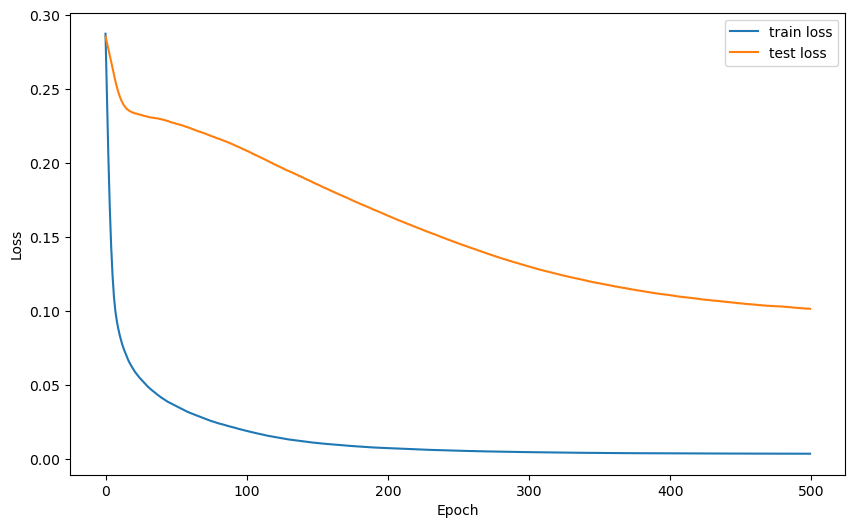

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [29]:
test_data = get_batch(test_rows, test_columns, test_sparse.data)
for row_batch, column_batch, rating_batch in test_data:
    predictions = model(row_batch, column_batch).detach().numpy()
    row_batch = row_batch.numpy()
    column_batch = column_batch.numpy()
    rating_batch = rating_batch.numpy()

    predictions_test = pd.DataFrame(
        {
            "user_id": row_batch,
            "isbn": column_batch,
            "rating": rating_batch,
            "prediction": predictions,
        }
    )
    break
predictions_test

,user_id,isbn,rating,prediction
0,12635,1172,1.000000,0.500000
1,17943,2529,0.888889,0.500000
2,22735,1540,0.777778,0.552564
3,3672,2818,0.777778,0.624437
4,15333,2541,0.444444,0.480082
...,...,...,...,...
995,8977,935,0.444444,0.457640
996,20493,1985,0.777778,0.649868
997,12263,1402,0.777778,0.500000
998,14047,452,0.888889,0.532961


In [30]:
train_data = get_batch(train_rows, train_columns, train_sparse.data)
for row_batch, column_batch, rating_batch in train_data:
    predictions = model(row_batch, column_batch).detach().numpy()
    row_batch = row_batch.numpy()
    column_batch = column_batch.numpy()
    rating_batch = rating_batch.numpy()

    predictions_train = pd.DataFrame(
        {
            "user_id": row_batch,
            "isbn": column_batch,
            "rating": rating_batch,
            "prediction": predictions,
        }
    )
    break
predictions_train

,user_id,isbn,rating,prediction
0,0,0,0.555556,0.514829
1,0,1,0.444444,0.446899
2,1,2,0.888889,0.894077
3,2,3,0.666667,0.697367
4,3,4,0.777778,0.780262
...,...,...,...,...
995,518,281,0.777778,0.759296
996,519,852,0.666667,0.694155
997,520,853,0.666667,0.659565
998,521,854,0.777778,0.743388


## Using ALS

ALS stands for Alternating Least Squares. It is an algorithm that solves the following optimization problem:

$$
\min_{U, V} \sum_{(i, j) \in \Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
$$

where $\Omega$ is the set of observed ratings. The algorithm alternates between the following two steps:

1. Fix $V$ and solve for $U$.
2. Fix $U$ and solve for $V$.
3. Repeat until convergence.

In [31]:
train_df_, test_df_ = split_dataframe(df_small, 0.15)
train_df_["provided_rating"] = train_df_["provided_rating"].apply(normalize_ratings)
test_df_["provided_rating"] = test_df_["provided_rating"].apply(normalize_ratings)


train_sparse = sparse.coo_matrix(
    (train_df_['provided_rating'].astype(np.float32),
        (train_df_['user_id'], train_df_['isbn']))
)
test_sparse = sparse.coo_matrix(
    (test_df_['provided_rating'].astype(np.float32),
    (test_df_['user_id'], test_df_['isbn']))
)

train_rows, train_columns = train_sparse.nonzero()
test_rows, test_columns = test_sparse.nonzero()

def get_batch(rows, columns, ratings, batch_size=1000):
    for start in range(0, len(rows), batch_size):
        end = min(start + batch_size, len(rows))
        rows_batch = rows[start:end]
        columns_batch = columns[start:end]
        ratings_batch = ratings[start:end]
        rows_batch = torch.LongTensor(rows_batch)
        columns_batch = torch.LongTensor(columns_batch)
        ratings_batch = torch.FloatTensor(ratings_batch)
        yield rows_batch, columns_batch, ratings_batch

In [32]:
embedding_dim = 30
n_users = df_small.user_id.nunique()
n_items = df_small.isbn.nunique()
U = torch.nn.Parameter(torch.randn(n_users, embedding_dim, requires_grad=True))
V = torch.nn.Parameter(torch.randn(n_items, embedding_dim, requires_grad=True))
# torch.nn.init.xavier_uniform(U)
# torch.nn.init.xavier_uniform(V)

def predict_ratings(user, item):
    prediction = (U[user] * V[item]).sum(1)
    prediction = torch.sigmoid(prediction)
    return prediction

l1_weight = 0
l2_weight = 0
lr = 0.01
u_optimizer = torch.optim.Adam([U], lr=lr)
v_optimizer = torch.optim.Adam([V], lr=lr)

scheduler_str = "plateau"
loss_func = MSE_L1L2Loss(model, l1_weight=l1_weight, l2_weight=l2_weight)
if scheduler_str == "plateau":
    u_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(u_optimizer, patience=10, verbose=True, min_lr=1e-7)
    v_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(v_optimizer, patience=10, verbose=True, min_lr=1e-7)
elif scheduler_str == "step":
    u_scheduler = torch.optim.lr_scheduler.StepLR(u_optimizer, step_size=30, gamma=0.1)
    v_scheduler = torch.optim.lr_scheduler.StepLR(v_optimizer, step_size=30, gamma=0.1)


In [33]:
def als_train_step(user, item, rating, optimizer_u, optimizer_v):
    optimizer_u.zero_grad()
    # optimizer_v.zero_grad()

    prediction_u = predict_ratings(user, item)
    loss_u = loss_func(prediction_u, rating)
    loss_u.backward()
    optimizer_u.step()
    optimizer_v.zero_grad()
    
    prediction_v = predict_ratings(user, item)
    loss_v = loss_func(prediction_v, rating)
    loss_v.backward()
    optimizer_v.step()
    return loss_u.item() , loss_v.item()

def als_test_step(user, item, rating):
    prediction = predict_ratings(user, item)
    loss = loss_func(prediction, rating)
    return loss.item()

In [34]:
epochs = 200
num_print = 10
print_freq = epochs // num_print
train_losses = []
test_losses = []

for epoch in tqdm(range(epochs), total=epochs, desc="Training..."):
    train_data = get_batch(train_rows, train_columns, train_sparse.data)
    test_data = get_batch(test_rows, test_columns, test_sparse.data)

    losses = []
    for row_batch, column_batch, rating_batch in train_data:
        loss_u, loss_v = als_train_step(row_batch, column_batch, rating_batch, u_optimizer, v_optimizer)
        loss = loss_u + loss_v
        losses.append(loss)
    train_loss = np.mean(losses)
    train_losses.append(train_loss)

    train_loss_u = np.mean(loss_u)
    train_loss_v = np.mean(loss_v)
    u_scheduler.step(train_loss_u)
    v_scheduler.step(train_loss_v)
    
    losses = []
    for row_batch, column_batch, rating_batch in test_data:
        loss = als_test_step(row_batch, column_batch, rating_batch)
        losses.append(loss)
    test_loss = np.mean(losses)
    test_losses.append(test_loss)

    if epoch % print_freq == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}: train loss = {train_loss}, test loss = {test_loss}")

Training...:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss = 0.556930897216643, test loss = 0.2790404395623641
Epoch 20: train loss = 0.11080517121140034, test loss = 0.2711117755283009
Epoch 40: train loss = 0.07221151912404646, test loss = 0.2576108520681208
Epoch 60: train loss = 0.047787392511963844, test loss = 0.24266499009999362
Epoch 80: train loss = 0.03165435842088153, test loss = 0.2297681434587999
Epoch 00091: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00091: reducing learning rate of group 0 to 1.0000e-03.
Epoch 100: train loss = 0.012222323446504531, test loss = 0.22260056977922266
Epoch 120: train loss = 0.009238690693652438, test loss = 0.22318654168735852
Epoch 140: train loss = 0.007331920605558422, test loss = 0.22393679076975043
Epoch 160: train loss = 0.005838947294602891, test loss = 0.2249736785888672
Epoch 00164: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00164: reducing learning rate of group 0 to 1.0000e-04.
Epoch 180: train loss = 0.005381882337162331, test loss = 0.2251943

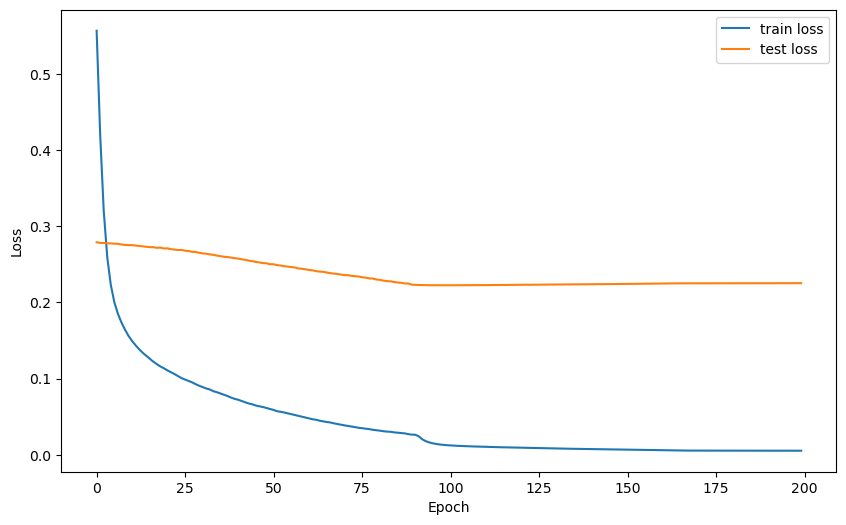

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [36]:
test_data = get_batch(test_rows, test_columns, test_sparse.data)
for row_batch, column_batch, rating_batch in test_data:
    predictions = predict_ratings(row_batch, column_batch).detach().numpy()
    row_batch = row_batch.numpy()
    column_batch = column_batch.numpy()
    rating_batch = rating_batch.numpy()

    predictions_test = pd.DataFrame(
        {
            "user_id": row_batch,
            "isbn": column_batch,
            "rating": rating_batch,
            "prediction": predictions,
        }
    )
    break
predictions_test

,user_id,isbn,rating,prediction
0,3419,2443,1.000000,0.234506
1,993,486,1.000000,0.074517
2,13962,94,0.555556,0.982237
3,830,751,0.444444,0.516354
4,20371,2001,0.666667,0.837317
...,...,...,...,...
995,993,1181,0.666667,0.791814
996,7266,14,1.000000,0.986061
997,12637,2784,0.666667,0.016166
998,18056,2357,0.555556,0.010672


In [37]:
train_data = get_batch(train_rows, train_columns, train_sparse.data)
for row_batch, column_batch, rating_batch in train_data:
    predictions = predict_ratings(row_batch, column_batch).detach().numpy()
    row_batch = row_batch.numpy()
    column_batch = column_batch.numpy()
    rating_batch = rating_batch.numpy()

    predictions_train = pd.DataFrame(
        {
            "user_id": row_batch,
            "isbn": column_batch,
            "rating": rating_batch,
            "prediction": predictions,
        }
    )
    break
predictions_train

,user_id,isbn,rating,prediction
0,0,0,0.555556,0.555583
1,1,2,0.888889,0.889288
2,2,3,0.666667,0.666710
3,3,4,0.777778,0.989298
4,4,5,0.777778,0.777821
...,...,...,...,...
995,525,864,0.555556,0.555164
996,525,636,0.666667,0.666893
997,525,866,0.666667,0.667081
998,525,428,0.444444,0.444012
